<a href="https://colab.research.google.com/github/lucas6028/aortic_valve_detection/blob/main/AI_CUP_2025_aortic_valve_object_detection_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1.設置環境

從畫面右上角確認有使用到GPU

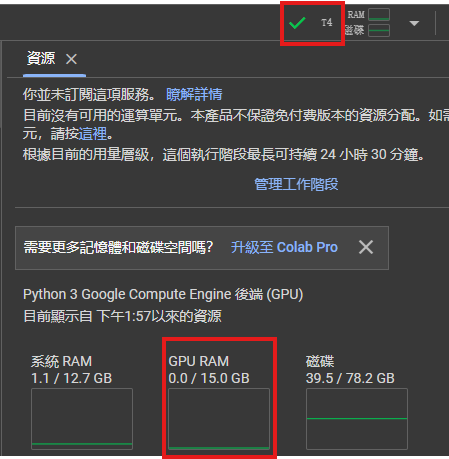

如果沒連到的話請切換到GPU

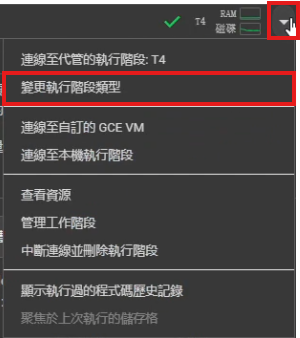
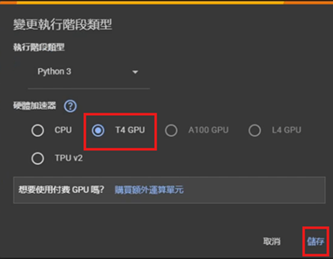

Colab區塊左方有綠色勾代表執行完成且成功 image.png


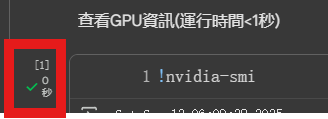

區塊左方有圈在轉代表執行中 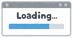

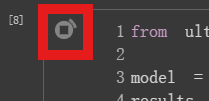

區塊左方有紅色驚嘆號代表運行錯誤 image.png

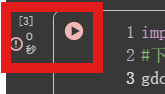

查看GPU資訊(運行時間<1秒) image.png

In [1]:
!nvidia-smi

Fri Oct 17 01:32:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

確保不會出現編碼錯誤(運行時間<1秒) image.png

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

下載YOLOv12套件(運行時間12秒) image.png

In [3]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.4/112.6 GB disk)


 #### 2. 上傳資料集

將testing_image.zip上傳至個人的Google雲端硬碟

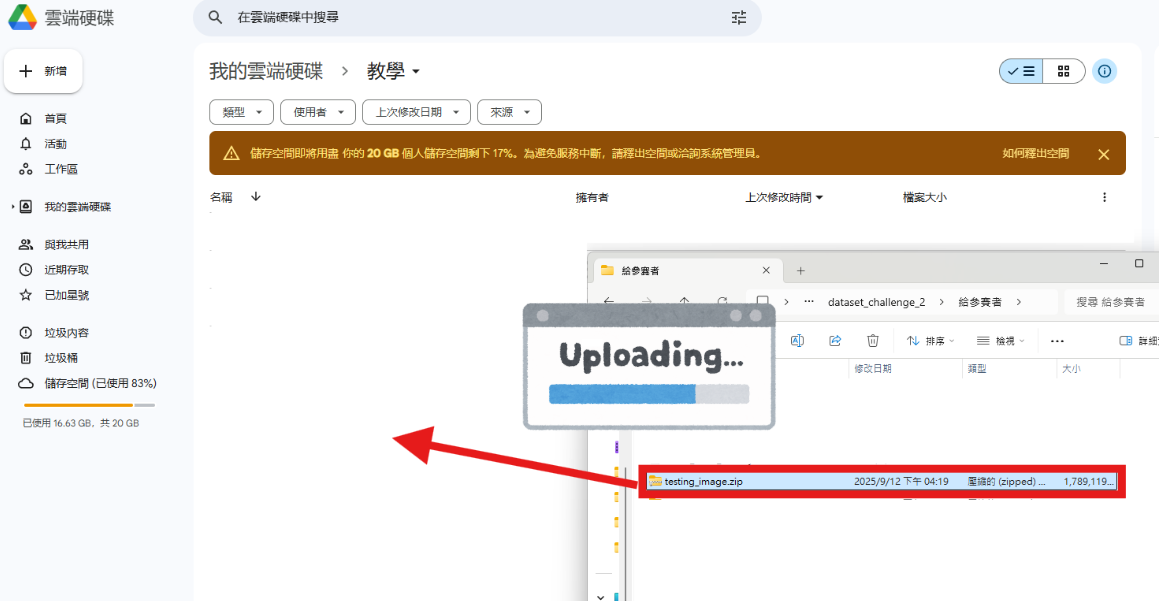

更改testing_image.zip檔案權限 image.png
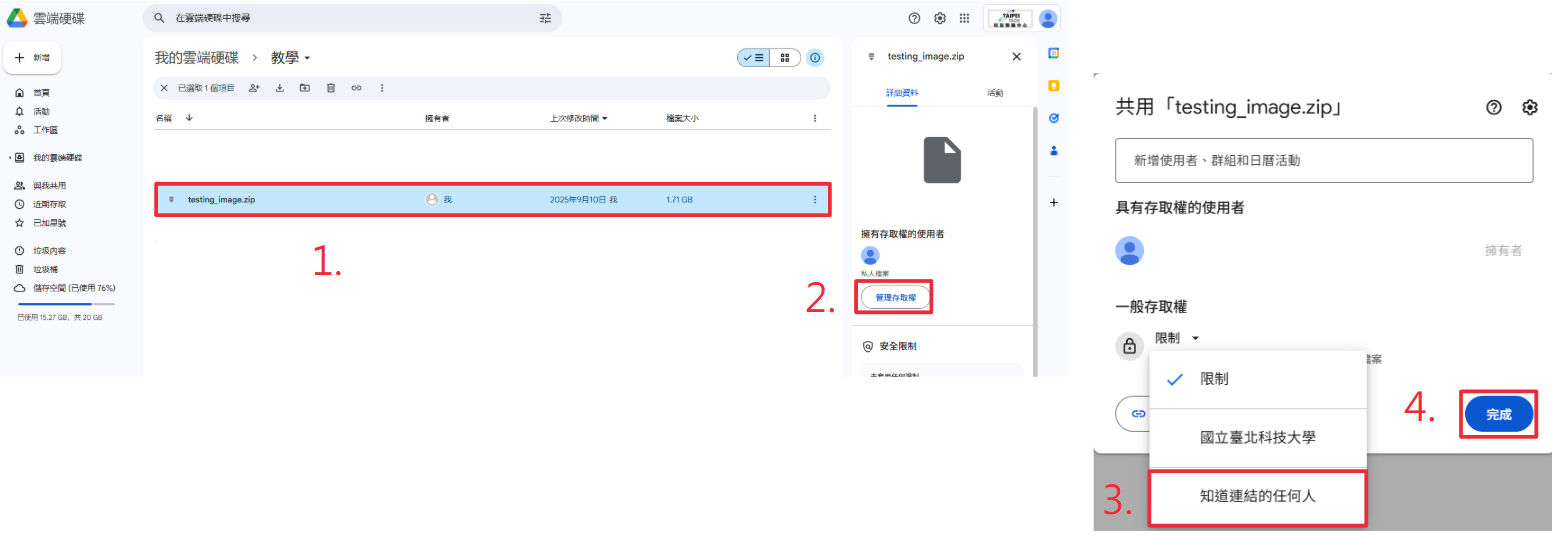

取得雲端資料下載連結(下方程式需要用到)

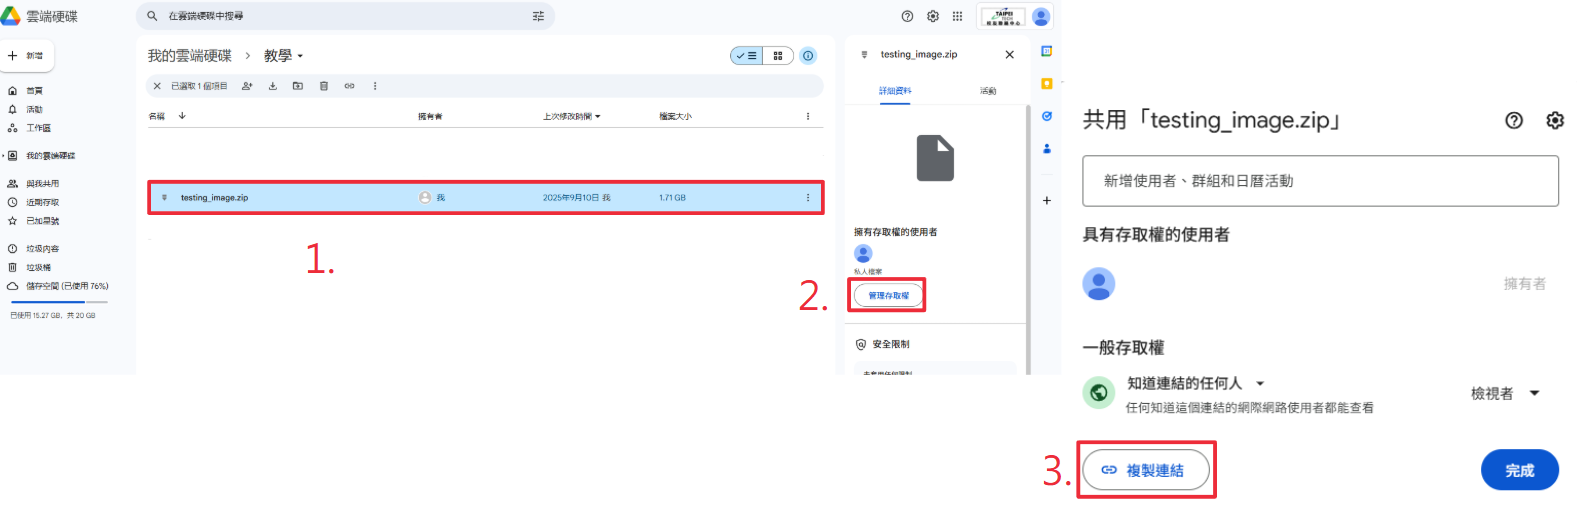

將剛剛取得的網址透過下方網址轉換成直接下載的格式


https://sites.google.com/view/twdrivefromdownload/%E7%B9%81%E9%AB%94%E4%B8%AD%E6%96%87traditional-chinese?authuser=0


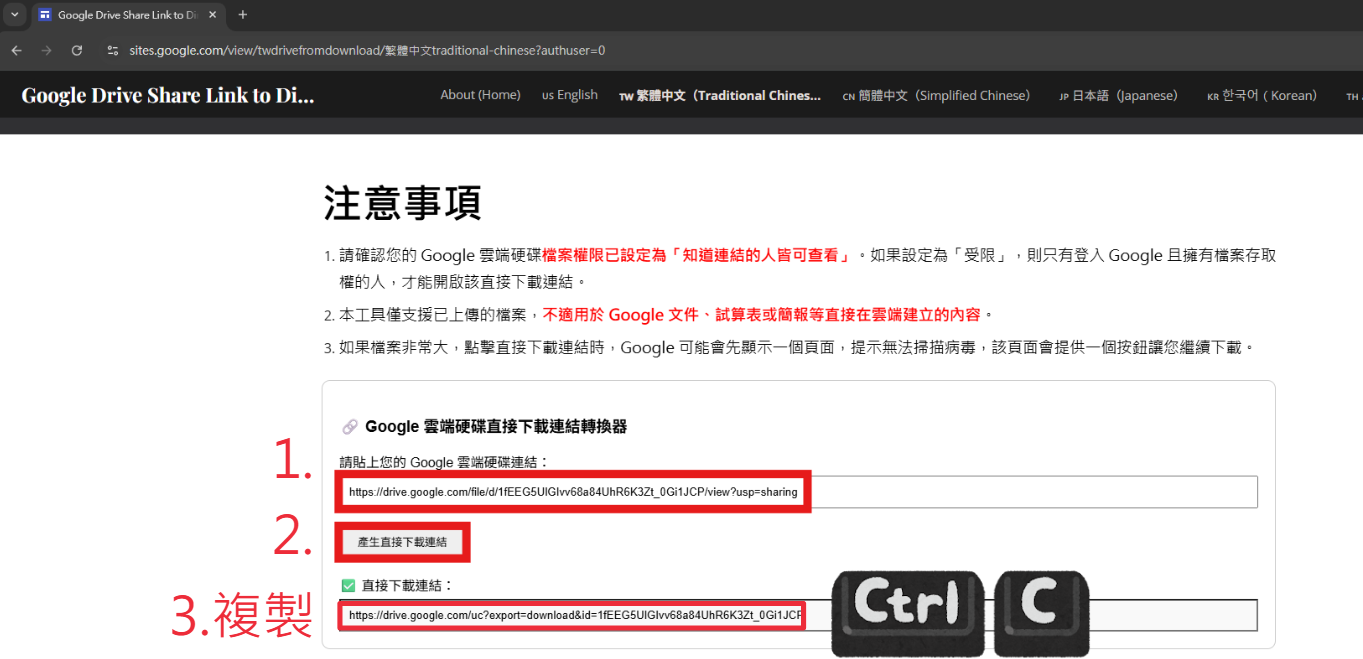

透過上面方法更改下方程式的網址(執行時間<1分鐘) image.png


 *請自行上傳雲端替換成自己的連結，此範例連結雖然與最初競賽資料集相同，但不保證會更新且隨時有可能會刪除!!!

In [4]:
#下載資料集
import gdown
import os
!mkdir ./datasets
!mkdir ./datasets/test
gdown.download("https://drive.google.com/uc?export=download&id=1drfMaRrfIL0XBRY16Vq9IJ3nJ2Zr9B60","/content/datasets/testing.zip")
!unzip '/content/datasets/testing' -d '/content/datasets/test/tmp'

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1drfMaRrfIL0XBRY16Vq9IJ3nJ2Zr9B60
From (redirected): https://drive.google.com/uc?export=download&id=1drfMaRrfIL0XBRY16Vq9IJ3nJ2Zr9B60&confirm=t&uuid=98226526-554e-4fe1-9ad1-95ead609ef0b
To: /content/datasets/testing.zip
100%|██████████| 1.83G/1.83G [00:18<00:00, 100MB/s]


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0078.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0079.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0080.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0081.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0082.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0083.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0084.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0085.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0086.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0087.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0088.png  


因為本競賽Testing資料集有16620張圖片，如果全部一起預測Colab的RAM會不足，所以將Testing圖片分成兩次做預測

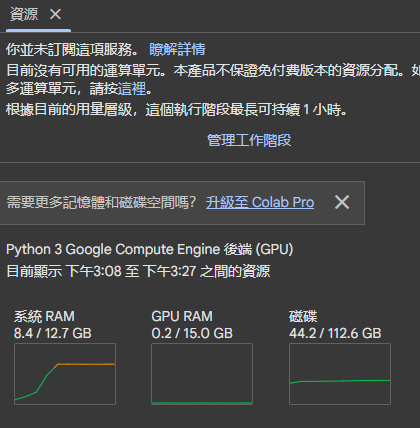

移動圖片位置(透過下方程式)


一半的圖片移至imges1資料夾，另一半移至imges2資料夾

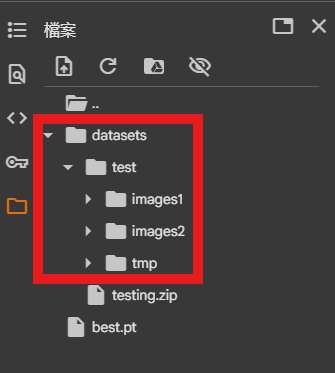

In [5]:
import os
import shutil

src_root = "/content/datasets/test/tmp/testing_image"
dst_root1 = "/content/datasets/test/images1"
dst_root2 = "/content/datasets/test/images2"

os.makedirs(dst_root1, exist_ok=True)
os.makedirs(dst_root2, exist_ok=True)

# 收集所有圖片路徑
all_files = []
for patient_folder in os.listdir(src_root):
    patient_path = os.path.join(src_root, patient_folder)
    if os.path.isdir(patient_path) and patient_folder.startswith("patient"):
        for fname in os.listdir(patient_path):
            if fname.endswith(".png"):
                all_files.append(os.path.join(patient_path, fname))

# 按照檔名排序，方便重現結果
all_files.sort()

# 計算一半
half = len(all_files) // 2

# 前半移到 images1/
for f in all_files[:half]:
    dst_file = os.path.join(dst_root1, os.path.basename(f))
    shutil.move(f, dst_file)

# 後半移到 images2/
for f in all_files[half:]:
    dst_file = os.path.join(dst_root2, os.path.basename(f))
    shutil.move(f, dst_file)

print(f"完成移動！總共 {len(all_files)} 張，前半 {half} 張放到 images1/，後半 {len(all_files)-half} 張放到 images2/")

完成移動！總共 16620 張，前半 8310 張放到 images1/，後半 8310 張放到 images2/


In [6]:
print('測試集圖片數量 : ',len(os.listdir("./datasets/test/images1"))+len(os.listdir("./datasets/test/images2")))

測試集圖片數量 :  16620


#### 3. Predict

下載模型權重檔(此權重檔為baseline提供的模型，參賽者可替換成自行訓練的模型檔)

In [7]:
#自行上傳權重檔請註解掉下方程式
gdown.download("https://drive.google.com/uc?export=download&id=1vucaHEPGLR8nWWJCeFr7YTA-o2i5c-tF","/content/best.pt")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1vucaHEPGLR8nWWJCeFr7YTA-o2i5c-tF
From (redirected): https://drive.google.com/uc?export=download&id=1vucaHEPGLR8nWWJCeFr7YTA-o2i5c-tF&confirm=t&uuid=a81303ec-457b-4720-98f6-e80622aeb54c
To: /content/best.pt
100%|██████████| 52.0M/52.0M [00:01<00:00, 50.6MB/s]


'/content/best.pt'

使用自行訓練模型可透過拖移方式上傳至Colab

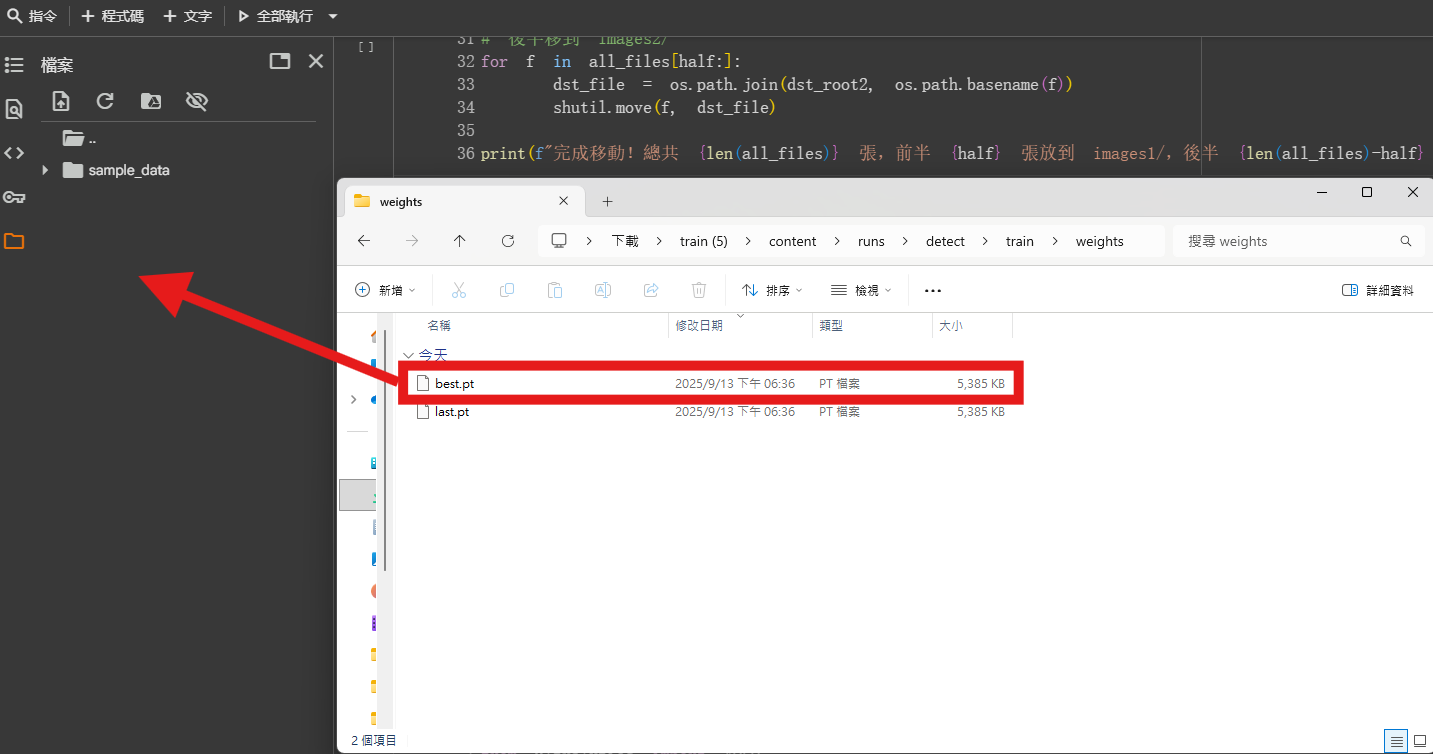

使用訓練過模型進行預測前半部分圖片(執行時間3分鐘)

In [8]:
from ultralytics import YOLO

model = YOLO('/content/best.pt')
results = model.predict(source="./datasets/test/images1/",
              save=True,
              imgsz=640,
              device=0,
              verbose=False,
              conf=0.001,
              iou=0.5,
              max_det=20
              )

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /content/runs/detect/predict


predict資料夾內**有圖片代表預測完成**


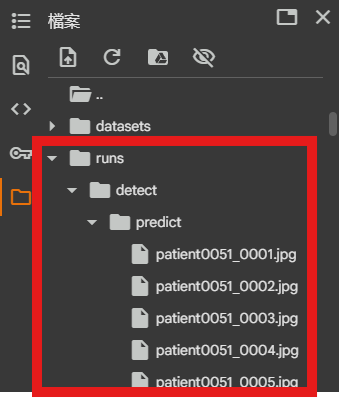

其中一張預測結果

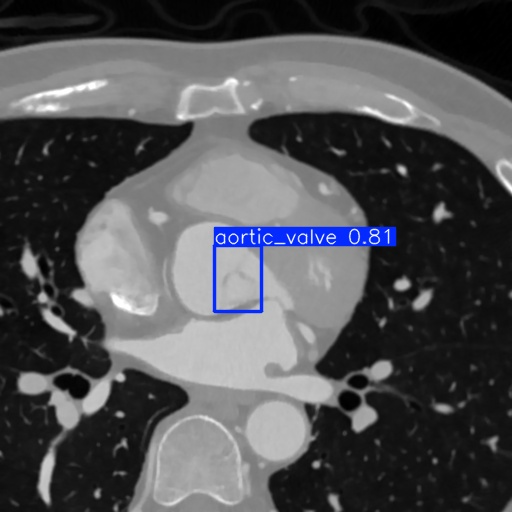

In [9]:
from IPython.display import Image

Image(filename='/content/runs/detect/predict/patient0051_0260.jpg', height=600)

預測數量

In [10]:
print(len(results))

8310


取得預測結果的資訊

想取得更多資訊可參考官方說明
https://docs.ultralytics.com/zh/modes/predict/#boxes

In [11]:
print('預測類別 : ',results[260].boxes.cls[0].item())
print('預測信心分數 : ',results[260].boxes.conf[0].item())
print('預測框座標 : ',results[260].boxes.xyxy[0].tolist())

預測類別 :  0.0
預測信心分數 :  0.8049934506416321
預測框座標 :  [212.6728057861328, 244.56982421875, 262.0451354980469, 312.4248962402344]


將偵測框數值寫進.txt檔

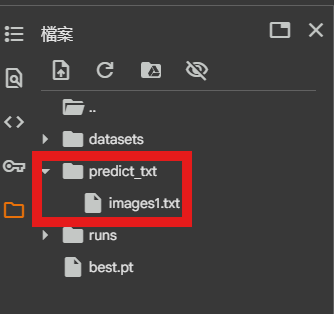

In [12]:
!mkdir ./predict_txt/
output_file = open('./predict_txt/images1.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()


釋放記憶體

因為Colab RAM不會自動釋放，所以透過程式釋放


In [13]:
import torch ,gc

# 刪除大型變數
del boxes,all_files,results
gc.collect()
torch.cuda.empty_cache()

預測後半圖片(執行時間3分鐘)

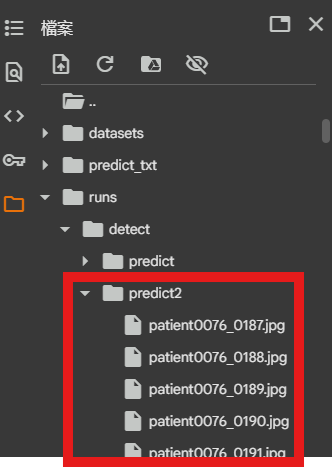

In [14]:
from ultralytics import YOLO

model = YOLO('/content/best.pt')
results = model.predict(source="./datasets/test/images2/",
              save=True,
              imgsz=640,
              device=0,
              verbose=False,
              conf=0.001,
              iou=0.5,
              max_det=20
              )

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /content/runs/detect/predict2


將後半部分偵測框數值寫進.txt檔

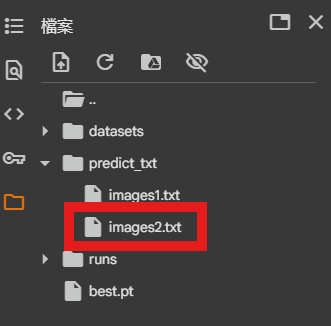

In [15]:
output_file = open('./predict_txt/images2.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()


合併兩個.txt

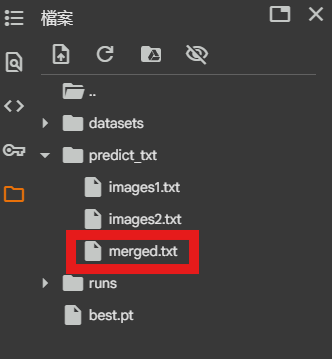

In [16]:
file1 = "./predict_txt/images1.txt"
file2 = "./predict_txt/images2.txt"
output = "./predict_txt/merged.txt"

with open(output, "w", encoding="utf-8") as fout:
    for f in [file1, file2]:
        if os.path.exists(f):
            with open(f, "r", encoding="utf-8") as fin:
                fout.writelines(fin.readlines())

print(f"合併完成 -> {output}")


合併完成 -> ./predict_txt/merged.txt


下載競賽提交txt  image.png

In [17]:
from google.colab import files
files.download('/content/predict_txt/merged.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

下載模型預測圖片(供參賽者參考用，不需要提交至競賽網頁) image.png

In [18]:
# !zip -r '/content/predict.zip' '/content/runs/detect/predict/' #打包預測結果
# !zip -r '/content/predict2.zip' '/content/runs/detect/predict2/' #打包預測結果
# from google.colab import files
# files.download('/content/predict.zip')
# files.download('/content/predict2.zip')

需等待進度條消失，才會完成下載

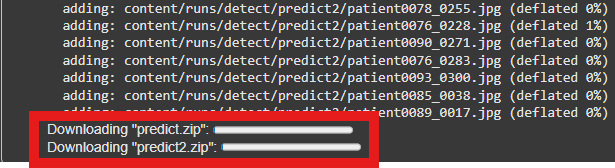